In [13]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.layers import Embedding
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models
from tensorflow.keras import layers, optimizers
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [14]:
UNIQUE_WORD_COUNT = 20000
MAX_SEQUENCE_LENGTH = 64

In [15]:
(training_data, training_targets), (testing_data, testing_targets) = imdb.load_data(num_words=UNIQUE_WORD_COUNT)
data = np.concatenate((training_data, testing_data), axis=0)
targets = np.concatenate((training_targets, testing_targets), axis=0)

In [16]:
def vectorize(sequences, dimension = UNIQUE_WORD_COUNT):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):      
        results[i, sequence] = 1
    return results

In [17]:
data = vectorize(data)
targets = np.array(targets).astype("float32")
print(len(data))
test_x = data[:10000]
test_y = targets[:10000]
# valid_x = data[5000:10000]
# valid_y = targets[5000:10000]
train_x = data[10000:]
train_y = targets[10000:]

50000


In [18]:
print(len(train_x))
# print(len(valid_x))
print(len(test_x))

40000
10000


In [22]:
def LNN():
    model = models.Sequential()
    
    model.add(layers.Dense(50, activation = "relu", input_shape=(20000, )))
    
    model.add(layers.Dropout(0.3, noise_shape=None, seed=None))
    model.add(layers.Dense(50, activation = "relu"))
    model.add(layers.Dropout(0.5, noise_shape=None, seed=None))
    model.add(layers.Dense(50, activation = "relu"))
    model.add(layers.Dropout(0.7, noise_shape=None, seed=None))
    
    model.add(layers.Dense(1, activation = "sigmoid"))
    model.summary()
    
    model.compile(
     optimizer = optimizers.Adam(learning_rate=0.00005),
     loss = "binary_crossentropy",
     metrics = ["accuracy"]
    )
    
    return model

In [23]:
model_LNN = LNN()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 50)                1000050   
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_14 (Dense)             (None, 50)                2550      
_________________________________________________________________
dropout_11 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_15 (Dense)             (None, 1)                

In [24]:
results_LNN_train = model_LNN.fit(
 train_x, train_y,
 epochs= 2,
 batch_size = 4,
 validation_data = (test_x, test_y)
)

Epoch 1/2
10000/10000 [==============================] - 25s 2ms/step - loss: 0.4847 - accuracy: 0.7681 - val_loss: 0.2751 - val_accuracy: 0.8912
Epoch 2/2
10000/10000 [==============================] - 24s 2ms/step - loss: 0.2736 - accuracy: 0.9046 - val_loss: 0.2565 - val_accuracy: 0.9027


In [25]:
results_LNN_test = model_LNN.evaluate(test_x, test_y)

313/313 [==============================] - 1s 2ms/step - loss: 0.2565 - accuracy: 0.9027


In [44]:
print(results_LNN_test)

[0.2564522325992584, 0.9027000069618225]


In [28]:
model_LNN.save('final_models/LNN/')

In [39]:
preds_model = np.asarray(model_LNN(test_x))
preds = []
for i in preds_model:
    if i>=0.5:
        preds.append(1)
    else:
        preds.append(0)
preds = np.asarray(preds)
preds

array([1, 0, 0, ..., 1, 0, 0])

In [40]:
test_y

array([1., 0., 0., ..., 1., 0., 0.], dtype=float32)

In [49]:
cm = confusion_matrix(test_y,preds)
cm

array([[4405,  542],
       [ 431, 4622]])

In [75]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.margins(x=1, y=1)
#     plt.gcf().subplots_adjust(left=0.15)
    plt.savefig('final_models/LNN/conf_matrix.png')

Confusion matrix, without normalization
[[4405  542]
 [ 431 4622]]


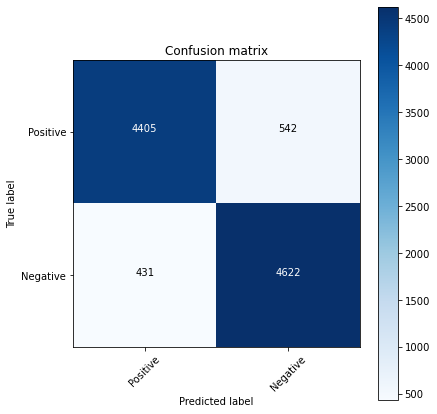

In [76]:
plot_confusion_matrix(cm, ["Positive", "Negative"])